<a href="https://colab.research.google.com/github/sushant1212/SAiDL-Summer-Assignment-2021/blob/main/cv/PseudoLabelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

[Errno 2] No such file or directory: '/content/drive/MyDrive/'
/content


In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15)
])


training_data = datasets.STL10(
    root="data",
    split="train",
    transform=transform,
    download=False
)

test_data = datasets.STL10(
    root="data",
    split='test',
    transform=transform,
    download=False
)

unlabeled = datasets.STL10(
    root="data",
    split="unlabeled",
    transform=transform,
    download=False
)

train_plus_unlabeled = datasets.STL10(
    root="data",
    split="train+unlabeled",
    transform=transform,
    download=False
)

In [ ]:
def imshow(img):
    t1 = torch.tensor([0.485, 0.456, 0.406])
    t2 = torch.tensor([0.229, 0.224, 0.225])
    img[0]*=t2[0]
    img[1]*=t2[1]
    img[2]*=t2[2]

    img[0]+=t1[0]
    img[1]+=t1[1]
    img[2]+=t1[2]

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

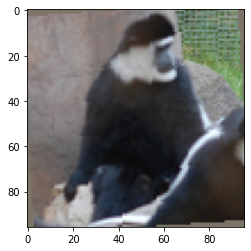

monkey
torch.Size([3, 96, 96])


In [ ]:
labels_map = {
    0: "airplane",
    1: "bird",
    2: "car",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "horse",
    7: "monkey",
    8: "ship",
    9: "truck",
}
img, label = training_data[155]
imshow(img)
print(labels_map[label])
print(img.shape)

In [ ]:

## HYPERPARAMETERS
BATCH_SIZE = 512
LR = 0.001
EPOCHS = 150



In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
unlabeled_dataloader = DataLoader(unlabeled, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

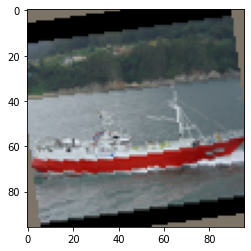

In [ ]:
unlabeled_features, labels = next(iter(unlabeled_dataloader))
img = unlabeled_features[0]
imshow(img)

In [ ]:
T1 = 100
T2 = 700
af = 3

def alpha_weight(step):
    if step < T1:
        return 0.0
    elif step > T2:
        return af
    else:
        return ((step-T1) / (T2-T1))*af

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.06),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.15),
            nn.Linear(6400, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.15),
            nn.Linear(512, 10),
        )


    def forward(self, x):        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x
       
        
model_ft = Net().cuda()
print(model_ft)

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.06, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(5, 

In [ ]:
model_ft.load_state_dict(torch.load('./saidl_cv_models/CNN_supervised.pt'))

<All keys matched successfully>

In [ ]:
def semisup_train(model, train_loader, unlabeled_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 100 
    
    model.train()
    for epoch in range(EPOCHS):
        print('Epoch {}/{}'.format(epoch, EPOCHS - 1))
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        for batch_idx, unlabeled_data in enumerate(unlabeled_loader):
            # Forward Pass to get the pseudo labels
            x_unlabeled, _ = unlabeled_data
            x_unlabeled = x_unlabeled.cuda()
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()          
           
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * nn.CrossEntropyLoss()(output, pseudo_labeled.data)   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            running_loss += unlabeled_loss.item() * x_unlabeled.size(0)
            _, preds = torch.max(output, 1)
            running_corrects += torch.sum(preds == pseudo_labeled.data)
            # For every 50 batches train one epoch on labeled data 
            if batch_idx % 50 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    X_batch = X_batch.cuda()
                    y_batch = y_batch.cuda()
                    output = model(X_batch)
                    labeled_loss = nn.CrossEntropyLoss()(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                    _, preds = torch.max(output, 1)
                    running_loss += labeled_loss.item() * X_batch.size(0)
                    running_corrects += torch.sum(preds == y_batch.data)
                # Now we increment step by 1
                step += 1
        epoch_loss = running_loss / (len(unlabeled_dataloader.dataset) + len(train_dataloader.dataset))
        epoch_acc = running_corrects.double() / (len(unlabeled_dataloader.dataset) + len(train_dataloader.dataset))
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('training', epoch_loss, epoch_acc))
        
        model.eval()
        running_loss_val = 0
        running_corrects_val = 0
        for inputs, labels in test_loader:
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                outputs = outputs.to(device)
                loss = nn.CrossEntropyLoss()(outputs, labels)

                _, preds = torch.max(outputs, 1)

            running_loss_val += loss.item() * input.size(0)
            running_corrects_val += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss_val/len(test_loader)
        epoch_acc_val = running_corrects.double() / len(test_loader)

        print()
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss_val, epoch_acc_val))



In [ ]:
torch.cuda.empty_cache()

In [ ]:
semisup_train(model_ft, train_dataloader, unlabeled_dataloader, test_dataloader)